# Trích xuất đặc trưng

## 1. Chuẩn bị dữ liệu

In [ ]:
# data with categorical columns encoded
!wget https://raw.githubusercontent.com/thanggnguyenn/data-for-everything/main/credit_card_churn_category_encoded.csv

# data with numerical columns min-max scaled
!wget https://raw.githubusercontent.com/thanggnguyenn/data-for-everything/main/credit_card_churn_min_max_scale_catgory_encoded.csv

# raw data for catboost
# !wget https://raw.githubusercontent.com/thanggnguyenn/data-for-everything/main/credit_card_churn_20_cols.csv

--2023-05-18 02:39:59--  https://raw.githubusercontent.com/thanggnguyenn/data-for-everything/main/credit_card_churn_category_encoded.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815006 (796K) [text/plain]
Saving to: ‘credit_card_churn_category_encoded.csv’

credit_card_churn_c 100%[===================>] 795.90K  --.-KB/s    in 0.05s   

2023-05-18 02:39:59 (17.1 MB/s) - ‘credit_card_churn_category_encoded.csv’ saved [815006/815006]

--2023-05-18 02:40:00--  https://raw.githubusercontent.com/thanggnguyenn/data-for-everything/main/credit_card_churn_min_max_scale_catgory_encoded.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

## 2. Thư viện

### SHAP, Boruta and CatBoost

In [1]:
!pip install shap
!pip install boruta
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.6 MB/s eta 0:00:00


### Thư viện xử lý dữ liệu

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
# import xgboost as xgb
# import catboost

import shap

## 3. Tải dữ liệu lên

In [ ]:
data = pd.read_csv("credit_card_churn_category_encoded.csv",index_col="CLIENTNUM")
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,1,45,-1,3,1,1,2,1,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,1,49,1,5,3,0,0,1,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
713982108,1,51,-1,3,3,1,3,1,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
769911858,1,40,1,4,1,-1,0,1,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
709106358,1,40,-1,3,0,1,2,1,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
data1 = pd.read_csv("credit_card_churn_min_max_scale_catgory_encoded.csv",index_col="CLIENTNUM")
data1.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Attrition_Flag
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,0.404255,0.6,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,0.392994,0.035273,0.248062,0.437534,0.061061,-1,1,1,2,1,1
818770008,0.489362,1.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,0.453636,0.043452,0.178295,1.000000,0.105105,1,3,0,0,1,1
713982108,0.531915,0.6,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,0.763615,0.076611,0.077519,0.628164,0.000000,-1,3,1,3,1,1
769911858,0.297872,0.8,0.488372,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,0.413600,0.036775,0.077519,0.628164,0.760761,1,1,-1,0,1,1
709106358,0.297872,0.6,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,0.640271,0.017025,0.139535,0.673129,0.000000,-1,0,1,2,1,1


In [ ]:
raw_data = pd.read_csv("credit_card_churn_20_cols.csv",index_col="CLIENTNUM")
raw_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
target = "Attrition_Flag"
X = data.drop(target,axis=1)
y = data[target]

X1 = data1.drop(target,axis=1)
y1 = data1[target]

raw_X = raw_data.drop(target,axis=1)
raw_y = raw_data[target]

## 4. Phân tích và chọn ra bộ thuộc tính tiềm năng

### Classifier object

#### Decision Tree

In [ ]:
tree = DecisionTreeClassifier(max_depth=5,class_weight="balanced")
tree.fit(X1,y1)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

In [ ]:
print("classes: ", tree.classes_)
print("n features in: ", tree.n_features_in_)

feat_importances_df = pd.DataFrame({"Name": tree.feature_names_in_,"Importance":tree.feature_importances_})
feat_importances_df

classes:  [0 1]
n features in:  19


,Name,Importance
0,Customer_Age,2.205102e-03
1,Dependent_count,0.000000e+00
2,Months_on_book,0.000000e+00
3,Total_Relationship_Count,6.189798e-02
4,Months_Inactive_12_mon,4.102872e-03
5,Contacts_Count_12_mon,1.650802e-03
6,Credit_Limit,8.012914e-03
7,Total_Revolving_Bal,1.170149e-01
8,Avg_Open_To_Buy,1.925428e-17
9,Total_Amt_Chng_Q4_Q1,7.237574e-03


**Nhận xét**: nhìn vào bảng trên, ta thấy những thuộc tính có độ quan trọng cao như: Total_Revolving_Bal (0.117), Total_Trans_Amt (0.183), Total_Trans_Ct (0.56).

#### RandomForest

In [ ]:
'''
  n_jobs = -1 --> all CPUs are used
  class_weight = balanced --> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to
  class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
  max_depth = 5 --> the maximum depth of the tree
'''
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

forest.fit(X1,y1)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [ ]:
print("classes: ", forest.classes_)
print("n features in: ", forest.n_features_in_)

feat_importances_df = pd.DataFrame({"Name": forest.feature_names_in_,"Importance":forest.feature_importances_})
feat_importances_df

classes:  [0 1]
n features in:  19


,Name,Importance
0,Customer_Age,0.005903
1,Dependent_count,0.000905
2,Months_on_book,0.005048
3,Total_Relationship_Count,0.042031
4,Months_Inactive_12_mon,0.025695
5,Contacts_Count_12_mon,0.024686
6,Credit_Limit,0.014561
7,Total_Revolving_Bal,0.130277
8,Avg_Open_To_Buy,0.015289
9,Total_Amt_Chng_Q4_Q1,0.047334


**Nhận xét:** những thuộc tính có độ quan trọng cao như: Total_Revolving_Bal (0.15), Total_Trans_Amt (0.24), Total_Trans_Ct (0.25), Total_Ct_Chng_Q4_Q1 (0.11).

#### XGBoost

In [ ]:
xgb_cl = xgb.XGBClassifier()
print(type(xgb_cl))

<class 'xgboost.sklearn.XGBClassifier'>


In [ ]:
xgb_cl.fit(X1,y1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### CatBoost

CatBoost là một thuật toán học máy với kiểu mã hóa (encode) dữ liệu dạng phân loại theo [ordered target statistics](https://arxiv.org/abs/1706.09516). Điều này làm cho thuật toán hoạt động hiệu quả hơn.

In [ ]:
raw_X.dtypes

Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [ ]:
raw_X

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,
768805383,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
713982108,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
769911858,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
709106358,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772366833,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
710638233,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
716506083,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


In [ ]:
from catboost import CatBoostClassifier

cat_features = list(raw_data.select_dtypes(exclude=np.number).columns.drop(target))

# Initialize CatBoostClassifier
model = CatBoostClassifier(learning_rate=0.5,
                           depth=5)
model.fit(raw_X,y,cat_features)

666:	learn: 0.0067739	total: 10.5s	remaining: 5.25s
667:	learn: 0.0067738	total: 10.5s	remaining: 5.23s
668:	learn: 0.0067738	total: 10.5s	remaining: 5.21s
669:	learn: 0.0067737	total: 10.6s	remaining: 5.2s
670:	learn: 0.0067736	total: 10.6s	remaining: 5.18s
671:	learn: 0.0067734	total: 10.6s	remaining: 5.16s
672:	learn: 0.0066794	total: 10.6s	remaining: 5.14s
673:	learn: 0.0066790	total: 10.6s	remaining: 5.13s
674:	learn: 0.0066790	total: 10.6s	remaining: 5.11s
675:	learn: 0.0066789	total: 10.6s	remaining: 5.09s
676:	learn: 0.0066789	total: 10.6s	remaining: 5.07s
677:	learn: 0.0066787	total: 10.6s	remaining: 5.06s
678:	learn: 0.0066787	total: 10.7s	remaining: 5.04s
679:	learn: 0.0066786	total: 10.7s	remaining: 5.03s
680:	learn: 0.0066786	total: 10.7s	remaining: 5.01s
681:	learn: 0.0066377	total: 10.7s	remaining: 4.99s
682:	learn: 0.0066374	total: 10.7s	remaining: 4.98s
683:	learn: 0.0066373	total: 10.7s	remaining: 4.96s
684:	learn: 0.0066372	total: 10.8s	remaining: 4.94s
685:	learn: 0

## 5. Sử dụng thư viện để chọn thuộc tính tiềm năng

### Boruta

#### Random Forest

In [ ]:
from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto')

# find all relevant features
feat_selector.fit(np.array(X), np.array(y))

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(np.array(X))

In [ ]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(data.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: Attrition_Flag            Rank: 1,  Keep: True
Feature: Customer_Age              Rank: 1,  Keep: True
Feature: Gender                    Rank: 2,  Keep: False
Feature: Dependent_count           Rank: 5,  Keep: False
Feature: Education_Level           Rank: 3,  Keep: False
Feature: Marital_Status            Rank: 1,  Keep: True
Feature: Income_Category           Rank: 4,  Keep: False
Feature: Card_Category             Rank: 1,  Keep: True
Feature: Months_on_book            Rank: 1,  Keep: True
Feature: Total_Relationship_Count  Rank: 1,  Keep: True
Feature: Months_Inactive_12_mon    Rank: 1,  Keep: True
Feature: Contacts_Count_12_mon     Rank: 1,  Keep: True
Feature: Credit_Limit              Rank: 1,  Keep: True
Feature: Total_Revolving_Bal       Rank: 1,  Keep: True
Feature: Avg_Open_To_Buy           Rank: 1,  Keep: True
Feature: Total_Amt_Chng_Q4_Q1      Rank: 1,  Keep: True
Feature: Total_Trans_Amt           Rank: 1,  Keep: True
Feature: Total_Trans_Ct            Rank: 1, 

**Nhận xét:** Những thuộc tính về thông tin cá nhân của khách hàng không được giữ lại, chỉ những thuộc tính về thông tin hoạt động tài khoản đóng góp vào sự hiệu quả của mô hình.

### SHAP

#### Giá trị SHAP của Decision Tree

In [ ]:
tree_explainer = shap.TreeExplainer(tree)

In [ ]:
tree_shap_values = tree_explainer.shap_values(X1)

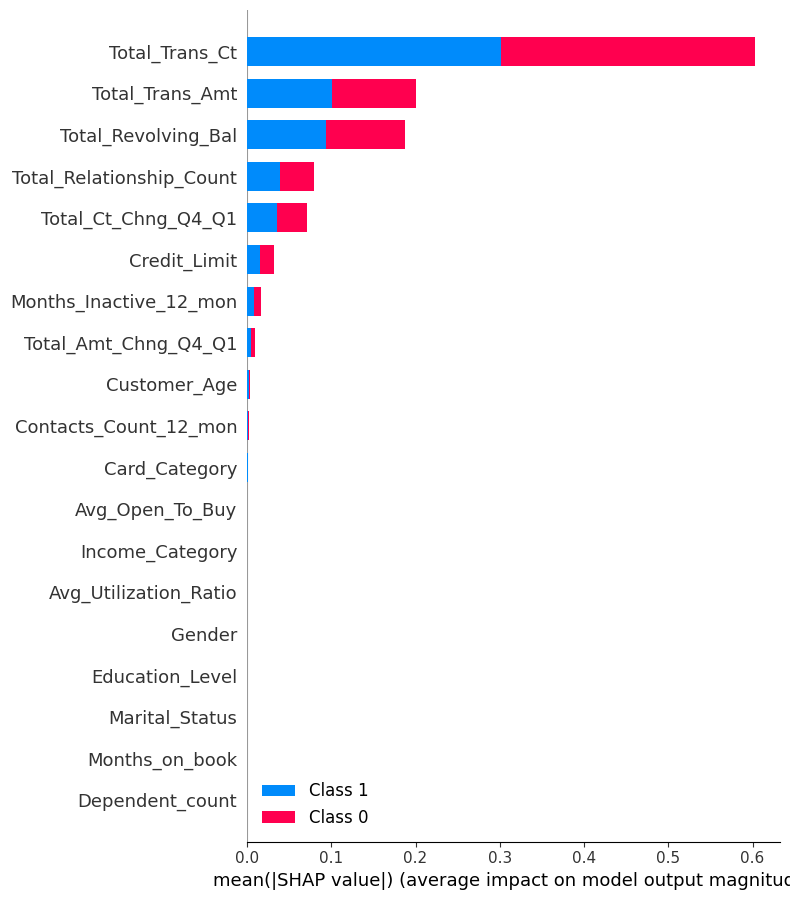

In [ ]:
# summarize the effects of all the features
shap.summary_plot(tree_shap_values, X1)

**Nhận xét**

Những thuộc tính góp phần vào việc tăng độ hiệu quả của việc dự đoán gồm: 
- Total_Trans_Ct, thay đổi xác suất dự đoán trung bình là 30%.
- Total_Trans_Amt và Total_Revolving_Bal thay đổi xác suất dự đoán trung bình là 20%.
- Total_Relationship_Count và Total_Ct_Chng_Q4_Q1 thay đổi xác suất dự đoán trung bình 5%.


#### Giá trị SHAP của Random Forest

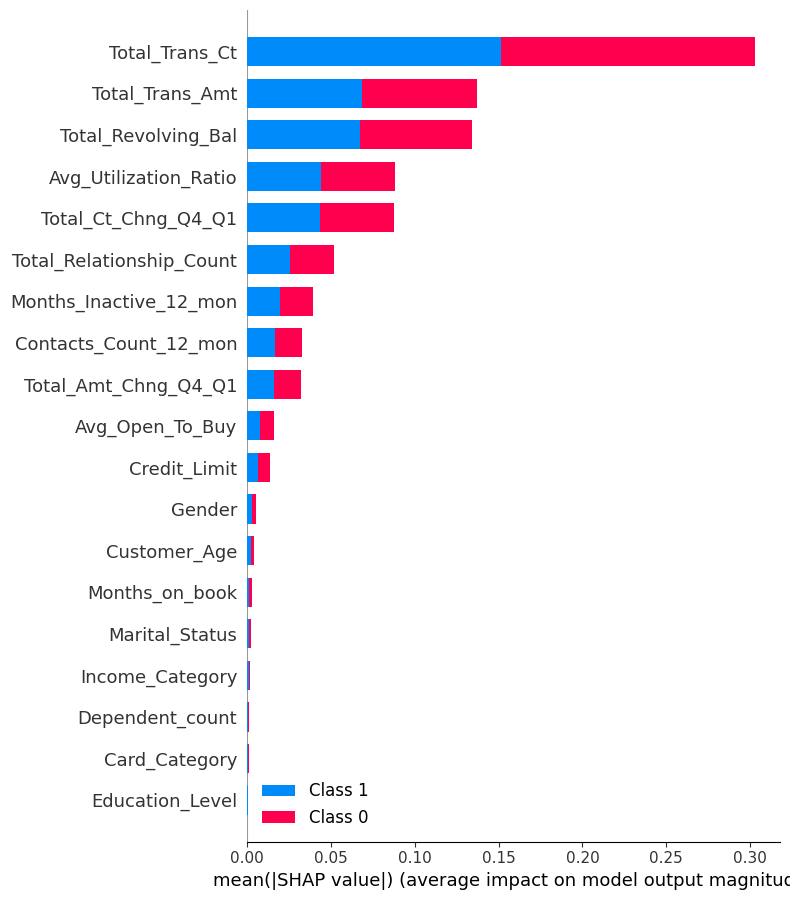

In [ ]:
forest_explainer = shap.TreeExplainer(forest)
forest_shap_values = forest_explainer.shap_values(X1,check_additivity=False)
shap.summary_plot(forest_shap_values, X1)

**Nhận xét**

|Tên thuộc tính|Xác suất dự đoán tăng trung bình|
|---|---|
|Total_Revolving_Bal|15%|
|Total_Relationship_Count|10%|
|Avg_Open_To_Buy|5%|
|Contacts_Count_12_mon|4%|
|Credit_Limit|4%|

Mô hình Random Forest có nhiều thuộc tính làm tăng độ chính xác của dự đoán hơn mô hình Decision Tree.

#### Giá trị SHAP của mô hình XGBoost

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


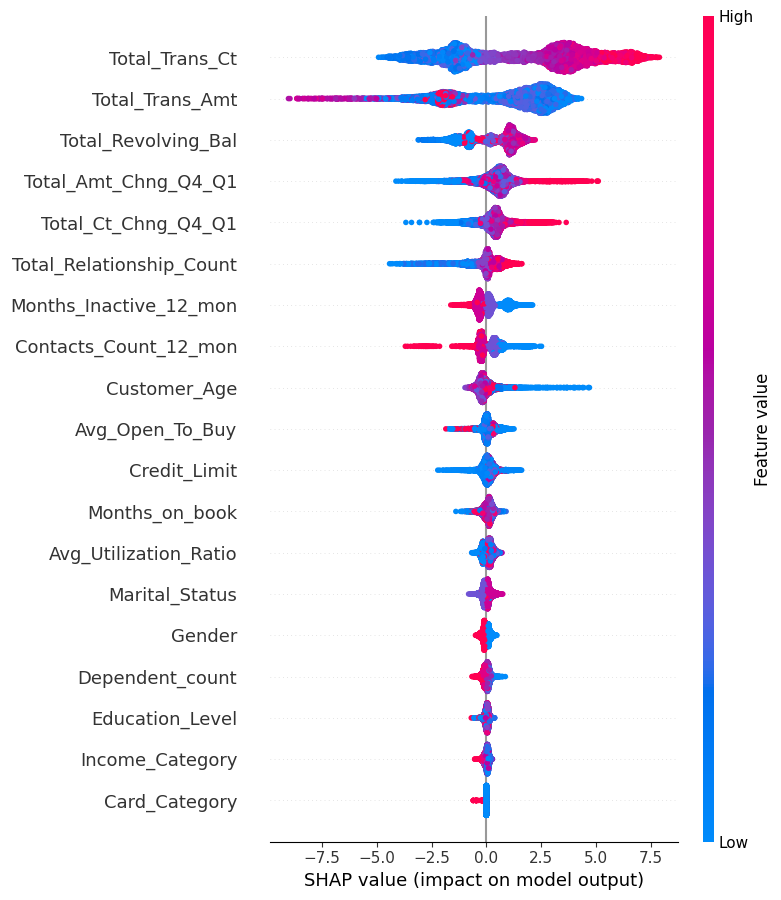

In [ ]:
xgboost_explainer = shap.TreeExplainer(xgb_cl)
xgboost_shap_values = xgboost_explainer.shap_values(X1) # ,check_additivity=False
shap.summary_plot(xgboost_shap_values, X1)

**Nhận xét**

|Thuộc tính|Giá trị|Ảnh hưởng tới mô hình|
|---|---|---|
|Total_Trans_Ct|Lớn|Tăng độ chính xác|
|Total_Trans_Amt|Nhỏ|Giảm độ chính xác|

#### Giá trị SHAP của CatBoost

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


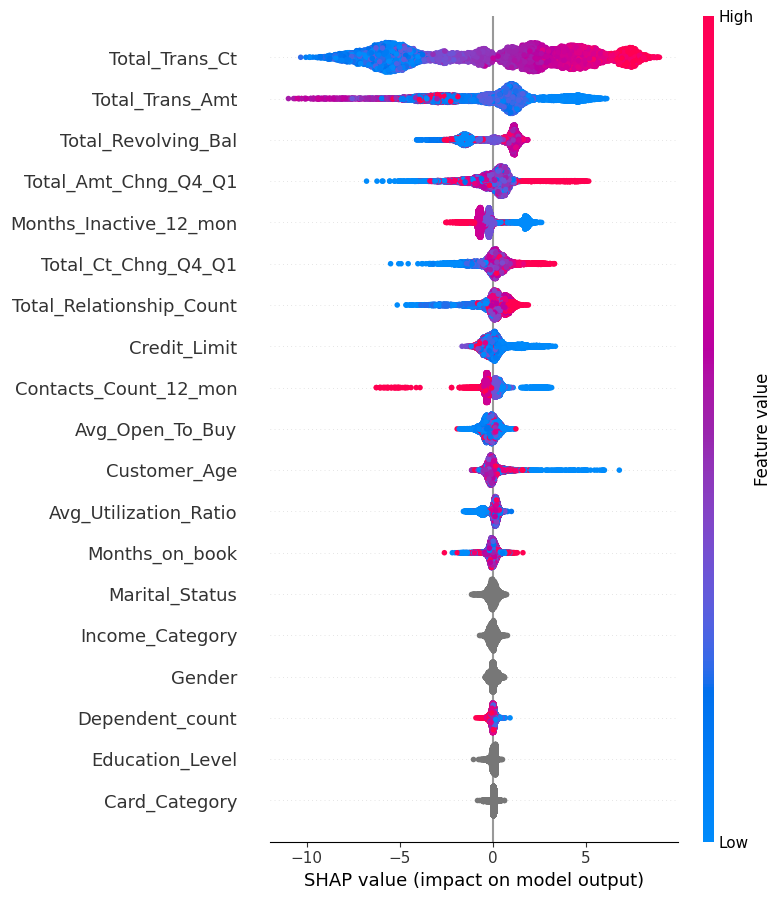

In [ ]:
catboost_explainer = shap.TreeExplainer(model)
catboost_shap_values = catboost_explainer.shap_values(raw_X) # ,check_additivity=False
shap.summary_plot(catboost_shap_values, raw_X)

**Nhận xét**

Những thuộc tính sau làm tăng độ chính xác của dự đoán

|Thuộc tính|Giá trị|
|---|---|
|Total_Trans_Ct|Lớn|
|Total_Trans_Amt|Nhỏ|
|Total_Amt_Chng_Q4_Q1|Lớn|
|Customer_Age|Nhỏ|
|Credit_Limit|Nhỏ|
|Total_Ct_Chng_Q4_Q1|Lớn|

## Chọn ra những thuộc tính tiềm năng

Nhóm sẽ bỏ những thuộc tính sau: Card_Category, Income_Category, Gender, Months_on_book, Marital_Status, Dependent_count, Education_Level.

Vì những thuộc tính trên có độ quan trọng (giá trị SHAP) thấp, không có đóng góp nhiều vào mô hình nên nhóm sẽ không sử dụng những thuộc tính này cho giai đoạn sau.

Những thuộc tính còn lại nhóm quyết định sẽ đưa vào mô hình.

## Rút trích đặc trưng

### Xử lý dữ liệu thiếu

Do dữ liệu không có giá trị thiếu hay dòng bị trùng nên nhóm không cần xử lý vấn đề này.

### Số hóa giá trị thuộc tính

Do nhóm không sử dụng những giá trị phân loại cho việc chạy mô hình nên không thực hiện việc số hóa giá trị thuộc tính.

### Tạo đặc trưng mới từ việc kết hợp các thuộc tính tiềm năng

Tạo ra đặc trưng số tiền giao dịch trên 1 lần giao dịch: Amt_per_Trans = Total_Trans_Amt / Total_Trans_Ct

In [ ]:
# data1.drop(["Card_Category", "Income_Category", "Gender", "Months_on_book", "Marital_Status", "Dependent_count", "Education_Level"],\
          #  axis=1,inplace=True)
data["Amt_per_Trans"] = data["Total_Trans_Amt"] / data["Total_Trans_Ct"]

scaler = MinMaxScaler()

data1["Amt_per_Trans"] = scaler.fit_transform(data["Amt_per_Trans"].to_numpy().reshape((-1,1)))

In [ ]:
data1

,Customer_Age,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Amt_per_Trans
CLIENTNUM,,,,,,,,,,,,,,
768805383,0.404255,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,0.392994,0.035273,0.248062,0.437534,0.061061,1,0.047354
818770008,0.489362,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,0.453636,0.043452,0.178295,1.000000,0.105105,1,0.116824
713982108,0.531915,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,0.763615,0.076611,0.077519,0.628164,0.000000,1,0.439695
769911858,0.297872,0.4,0.666667,0.166667,0.056676,1.000000,0.022977,0.413600,0.036775,0.077519,0.628164,0.760761,1,0.230405
709106358,0.297872,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,0.640271,0.017025,0.139535,0.673129,0.000000,1,0.058489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772366833,0.510638,0.4,0.333333,0.500000,0.077536,0.735399,0.062266,0.206947,0.832647,0.829457,0.230749,0.462462,1,0.661398
710638233,0.319149,0.6,0.333333,0.500000,0.085819,0.868494,0.060499,0.236679,0.459219,0.457364,0.183899,0.511512,0,0.630653
716506083,0.382979,0.8,0.500000,0.666667,0.120042,0.000000,0.156637,0.241095,0.544175,0.387597,0.220248,0.000000,0,0.890816


In [ ]:
# xóa cột Avg_Open_To_Buy do cột hai cột Avg_Open_To_Buy và Credit_Limit có hệ số tương quan là 1.
data1.drop(["Avg_Open_To_Buy"], axis =1, inplace=True)

In [ ]:
data1.to_csv("feature_extracted_data.csv")